# Elliptical Sheared Lenses — Amplification Factor

This notebook computes and visualises the gravitational-wave amplification
factor $F(\omega, \mathbf{y})$ for two families of elliptical lens models
combined with an external shear field:

1. **Elliptical Power-Law (EPL)** — varying the slope $\gamma$ at fixed
   ellipticity and shear, using both the Type-1 (grid) and Type-3 (scattered)
   NUFFT back-ends of FIONA's `FresnelNUFFT3` solver.
2. **Elliptical NFW** — varying the concentration $c_{200}$ at fixed halo mass,
   redshift, ellipticity, and shear.

Each figure is a grid where **rows** correspond to the lens parameter being
varied and **columns** to the dimensionless frequency $\omega$.
A shared colour scale is used within each row so the change in the interference
pattern with frequency can be read off directly.


## 1. Environment Setup

FIONA caches 2-D Gauss–Legendre quadrature grids on disk.  
Set `FIONA_GL2D_DIR` to a writable directory **before** importing FIONA so the
cache is found (or created) correctly.  
Adjust the path and thread counts to match your hardware.


In [1]:
%matplotlib inline

import os

# Directory where FIONA stores pre-computed 2-D Gauss-Legendre grids.
# Override by setting FIONA_GL2D_DIR in your shell before launching the notebook.
os.environ["FIONA_GL2D_DIR"] = os.environ.get(
    "FIONA_GL2D_DIR",
    "/n/netscratch/dvorkin_lab/Lab/nephremidze/2-LISA/0-parallel/fift_gl2d"
)

# Set to "1" to raise an error if a required grid is missing from the cache.
os.environ["FIONA_GL2D_STRICT"] = os.environ.get("FIONA_GL2D_STRICT", "0")

# Maximum number of OpenMP threads used by the NUFFT library.
os.environ["OMP_NUM_THREADS"] = os.environ.get("OMP_NUM_THREADS", "112")


## 2. Imports


In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# Lens models and NUFFT solver
from fiona import EPL, Shear, set_num_threads, FresnelNUFFT3

# Use up to 112 threads (adjust to your hardware)
set_num_threads(112)


## 3. Composite Lens

A `CompositeLens` wraps an arbitrary number of individual lens components and
computes the total lensing potential as their sum.  It is used throughout this
notebook to combine an elliptical main lens with an external shear field.


In [3]:
class CompositeLens:
    """Sum the lensing potentials of one or more individual lens components.

    Parameters
    ----------
    *lenses :
        Any number of lens objects that expose a ``psi_xy(x1, x2)`` method.
    """

    def __init__(self, *lenses):
        self.lenses = lenses

    def psi_xy(self, x1, x2):
        """Return the combined lensing potential evaluated at positions (x1, x2)."""
        psi = 0.0
        for lens in self.lenses:
            psi = psi + lens.psi_xy(x1, x2)
        return psi


## 4. EPL + External Shear

The **Elliptical Power-Law** (EPL) model generalises the singular isothermal
sphere to an arbitrary slope $\gamma$ and projected ellipticity $(e_1, e_2)$.
An external shear $(\gamma_1^{\rm ext}, \gamma_2^{\rm ext})$ is superposed to
mimic the tidal field of the surrounding matter distribution.

The amplification factor is computed on an $N_x \times N_y$ Cartesian grid in
the source plane for each combination of $\gamma$ (rows) and $\omega$ (columns).

Two FIONA back-ends are provided:

- **Type-1** (`use_type1_grid=True`): evaluates $F$ on a uniform grid directly
  from the quadrature nodes — fast for dense grids and multiple frequencies.
- **Type-3** (`use_type1_grid=False`): evaluates $F$ at arbitrary scattered
  target points — more flexible, same accuracy.


### 4.1 Type-1 NUFFT helper

Builds one EPL + shear lens per $\gamma$ value, runs the Type-1 NUFFT for all
requested frequencies simultaneously, and displays the row-normalised
magnification maps.


In [4]:
def plot_EPL_shear_gamma_w_grid_row_colorbars_type1(
    gamma_list=(1.2, 1.7, 2.2),
    w_list=(1.0, 10.0, 100.0),
    e1=0.2,
    e2=0.0,
    theta_E=1.0,
    shear_g1=0.03,
    shear_g2=0.01,
    gl_nodes_per_dim=5000,
    min_physical_radius=500.0,
    nufft_tol=1e-9,
    numexpr_nthreads=1,
    y_extent=1.5,
    Ny=500,
    Nx=500,
    cmap="magma",
    font_size=17,
    verbose=False,
):
    """Plot |F(omega, y)| for EPL + external shear using the Type-1 NUFFT back-end.

    The grid is laid out as ``len(gamma_list)`` rows x ``len(w_list)`` columns.
    Each row shares a single colour normalisation so brightness can be compared
    across frequencies.  One colourbar is drawn per row.

    Parameters
    ----------
    gamma_list : sequence of float
        EPL power-law slopes to display (one per row).
    w_list : sequence of float
        Dimensionless frequencies omega (one per column).
    e1, e2 : float
        Complex ellipticity components of the EPL lens.
    theta_E : float
        Einstein radius of the EPL lens [arcsec].
    shear_g1, shear_g2 : float
        External shear components.
    gl_nodes_per_dim : int
        Number of Gauss-Legendre nodes per dimension for the quadrature grid.
    min_physical_radius : float
        Inner cut-off radius for the GL grid [physical units].
    nufft_tol : float
        Requested NUFFT accuracy.
    numexpr_nthreads : int
        Number of numexpr threads used for potential evaluation.
    y_extent : float
        Half-width of the source-plane grid in dimensionless units.
    Ny, Nx : int
        Number of pixels along each axis.
    cmap : str
        Matplotlib colour map name.
    font_size : int
        Base font size for axis labels and titles.
    verbose : bool
        Pass through to FresnelNUFFT3 for diagnostic output.
    """
    plt.rcParams.update({
        "font.family": "serif",
        "mathtext.fontset": "cm",
        "font.size": font_size,
    })

    gamma_list = list(gamma_list)
    w_list = np.asarray(w_list, dtype=float)

    # Build the Cartesian source-plane grid
    y1 = np.linspace(-y_extent, y_extent, Nx)
    y2 = np.linspace(-y_extent, y_extent, Ny)
    Y1, Y2 = np.meshgrid(y1, y2, indexing="xy")

    fig, axes = plt.subplots(
        len(gamma_list),
        len(w_list),
        figsize=(5 * len(w_list), 5 * len(gamma_list)),
        constrained_layout=True,
    )

    t0 = time.perf_counter()

    for i, gamma in enumerate(gamma_list):
        # Build the EPL + external-shear composite lens for this row
        lens_epl = EPL(
            theta_E=theta_E,
            gamma=gamma,
            e1=e1,
            e2=e2,
            center_x=0.0,
            center_y=0.0,
        )
        shear = Shear(
            gamma1=shear_g1,
            gamma2=shear_g2,
            ra_0=0.0,
            dec_0=0.0,
        )
        lens = CompositeLens(lens_epl, shear)

        # Initialise the Type-1 NUFFT solver
        nu3 = FresnelNUFFT3(
            lens,
            gl_nodes_per_dim=gl_nodes_per_dim,
            min_physical_radius=min_physical_radius,
            nufft_tol=nufft_tol,
            auto_R_from_gl_nodes=True,
            use_tail_correction=True,
            window_potential=True,
            window_u=True,
            coordinate_system="cartesian",
            numexpr_nthreads=numexpr_nthreads,
            parallel_frequencies=True,
            nufft_workers=112,
            nufft_nthreads=1,
            # Type-1 specific settings
            use_type1_grid=True,
            type1_interpolate=False,
            type1_iflag=1,
            type1_fftshift=True,
            type1_modeord=1,
            type1_output="kgrid",
            verbose=verbose,
        )

        # Compute F for all frequencies in a single pass
        out = nu3(w_list, Y1, Y2)
        F_list = out["F"]
        y_axes = out["y_axes"]

        # Row-wise colour normalisation
        norm = Normalize(
            vmin=float(min(np.abs(F).min() for F in F_list)),
            vmax=float(max(np.abs(F).max() for F in F_list)),
        )

        for j, w in enumerate(w_list):
            t_sub0 = time.perf_counter()
            F_k = F_list[j]
            y_axis_w = y_axes[j]
            ax = axes[i, j]

            ax.imshow(
                np.abs(F_k).T,
                origin="lower",
                extent=[
                    y_axis_w.min(), y_axis_w.max(),
                    y_axis_w.min(), y_axis_w.max(),
                ],
                norm=norm,
                aspect="equal",
                cmap=cmap,
            )

            if i == 0:
                ax.set_title(rf'$\omega={w:g}$')
            if j == 0:
                ax.set_ylabel(rf'$\gamma={gamma}$' + '\n' + r'$y_2$')
            else:
                ax.set_ylabel("")
            ax.set_xlabel(r'$y_1$')

            t_sub1 = time.perf_counter()
            print(f"[Type-1] gamma={gamma:g}, w={w:g}, time={t_sub1 - t_sub0:.4f}s")

        # One colourbar per row, anchored to all columns in that row
        cbar = fig.colorbar(
            axes[i, -1].images[-1],
            ax=axes[i, :],
            shrink=0.95,
            pad=0.02,
        )
        cbar.set_label(r'$|F(\omega,\mathbf{y})|$')

    print(f"Total time: {time.perf_counter() - t0:.2f}s")
    plt.show()


### 4.2 Type-3 NUFFT helper

Same layout as the Type-1 version but uses the **Type-3** (scattered-points)
NUFFT back-end.  This is the default for general source-plane geometries and
typically requires a smaller `min_physical_radius` cut-off.


In [5]:
def plot_EPL_shear_gamma_w_grid_row_colorbars_type3(
    gamma_list=(1.2, 1.7, 2.2),
    w_list=(1.0, 10.0, 100.0),
    e1=0.2,
    e2=0.0,
    theta_E=1.0,
    shear_g1=0.03,
    shear_g2=0.01,
    gl_nodes_per_dim=5000,
    min_physical_radius=10.0,
    nufft_tol=1e-9,
    numexpr_nthreads=1,
    y_extent=1.5,
    Ny=500,
    Nx=500,
    cmap="magma",
    font_size=17,
    verbose=False,
):
    """Plot |F(omega, y)| for EPL + external shear using the Type-3 NUFFT back-end.

    Layout, colour normalisation, and colourbar placement are identical to
    :func:`plot_EPL_shear_gamma_w_grid_row_colorbars_type1`; only the NUFFT
    configuration differs (``use_type1_grid=False``).

    Parameters
    ----------
    gamma_list : sequence of float
        EPL power-law slopes to display (one per row).
    w_list : sequence of float
        Dimensionless frequencies omega (one per column).
    e1, e2 : float
        Complex ellipticity components of the EPL lens.
    theta_E : float
        Einstein radius of the EPL lens [arcsec].
    shear_g1, shear_g2 : float
        External shear components.
    gl_nodes_per_dim : int
        Number of Gauss-Legendre nodes per dimension for the quadrature grid.
    min_physical_radius : float
        Inner cut-off radius for the GL grid [physical units].
    nufft_tol : float
        Requested NUFFT accuracy.
    numexpr_nthreads : int
        Number of numexpr threads used for potential evaluation.
    y_extent : float
        Half-width of the source-plane grid in dimensionless units.
    Ny, Nx : int
        Number of pixels along each axis.
    cmap : str
        Matplotlib colour map name.
    font_size : int
        Base font size for axis labels and titles.
    verbose : bool
        Pass through to FresnelNUFFT3 for diagnostic output.
    """
    plt.rcParams.update({
        "font.family": "serif",
        "mathtext.fontset": "cm",
        "font.size": font_size,
    })

    gamma_list = list(gamma_list)
    w_list = np.asarray(w_list, dtype=float)

    # Build the Cartesian source-plane grid
    y1 = np.linspace(-y_extent, y_extent, Nx)
    y2 = np.linspace(-y_extent, y_extent, Ny)
    Y1, Y2 = np.meshgrid(y1, y2, indexing="xy")

    fig, axes = plt.subplots(
        len(gamma_list),
        len(w_list),
        figsize=(5 * len(w_list), 5 * len(gamma_list)),
        constrained_layout=True,
    )

    t0 = time.perf_counter()

    for i, gamma in enumerate(gamma_list):
        # Build the EPL + external-shear composite lens for this row
        lens_epl = EPL(
            theta_E=theta_E,
            gamma=gamma,
            e1=e1,
            e2=e2,
            center_x=0.0,
            center_y=0.0,
        )
        shear = Shear(
            gamma1=shear_g1,
            gamma2=shear_g2,
            ra_0=0.0,
            dec_0=0.0,
        )
        lens = CompositeLens(lens_epl, shear)

        # Initialise the Type-3 NUFFT solver
        nu3 = FresnelNUFFT3(
            lens,
            gl_nodes_per_dim=gl_nodes_per_dim,
            min_physical_radius=min_physical_radius,
            nufft_tol=nufft_tol,
            auto_R_from_gl_nodes=True,
            use_tail_correction=True,
            window_potential=True,
            window_u=True,
            coordinate_system="cartesian",
            numexpr_nthreads=numexpr_nthreads,
            parallel_frequencies=True,
            nufft_workers=112,
            nufft_nthreads=1,
            use_type1_grid=False,  # force Type-3
            verbose=verbose,
        )

        # Compute F for all frequencies in a single pass
        F = nu3(w_list, Y1, Y2, verbose=False)
        Fabs = np.abs(F)

        # Row-wise colour normalisation
        norm = Normalize(vmin=float(Fabs.min()), vmax=float(Fabs.max()))

        for j, w in enumerate(w_list):
            t_sub0 = time.perf_counter()
            frame = Fabs[j]
            ax = axes[i, j]

            ax.imshow(
                frame,
                origin="lower",
                extent=[y1.min(), y1.max(), y2.min(), y2.max()],
                norm=norm,
                aspect="equal",
                cmap=cmap,
            )

            if i == 0:
                ax.set_title(rf'$\omega={w:g}$')
            if j == 0:
                ax.set_ylabel(rf'$\gamma={gamma}$' + '\n' + r'$y_2$')
            else:
                ax.set_ylabel("")
            ax.set_xlabel(r'$y_1$')

            t_sub1 = time.perf_counter()
            print(f"[Type-3] gamma={gamma:g}, w={w:g}, time={t_sub1 - t_sub0:.4f}s")

        # One colourbar per row, anchored to all columns in that row
        cbar = fig.colorbar(
            axes[i, -1].images[-1],
            ax=axes[i, :],
            shrink=0.95,
            pad=0.02,
        )
        cbar.set_label(r'$|F(\omega,\mathbf{y})|$')

    print(f"Total time: {time.perf_counter() - t0:.2f}s")
    plt.show()


### 4.3 Generate the EPL maps (Type-3)

The amplification factor is evaluated on a 500 × 500 grid for three EPL slopes
$\gamma \in \{1.2,\, 1.7,\, 2.2\}$ and frequencies
$\omega \in \{1, 10, 100\}$.


[Type-3] gamma=1.2, w=1, time=0.0023s
[Type-3] gamma=1.2, w=10, time=0.0022s
[Type-3] gamma=1.2, w=100, time=0.0009s
[Type-3] gamma=1.7, w=1, time=0.0019s
[Type-3] gamma=1.7, w=10, time=0.0023s
[Type-3] gamma=1.7, w=100, time=0.0010s
[Type-3] gamma=2.2, w=1, time=0.0020s
[Type-3] gamma=2.2, w=10, time=0.0021s
[Type-3] gamma=2.2, w=100, time=0.0009s
Total time: 95.12s


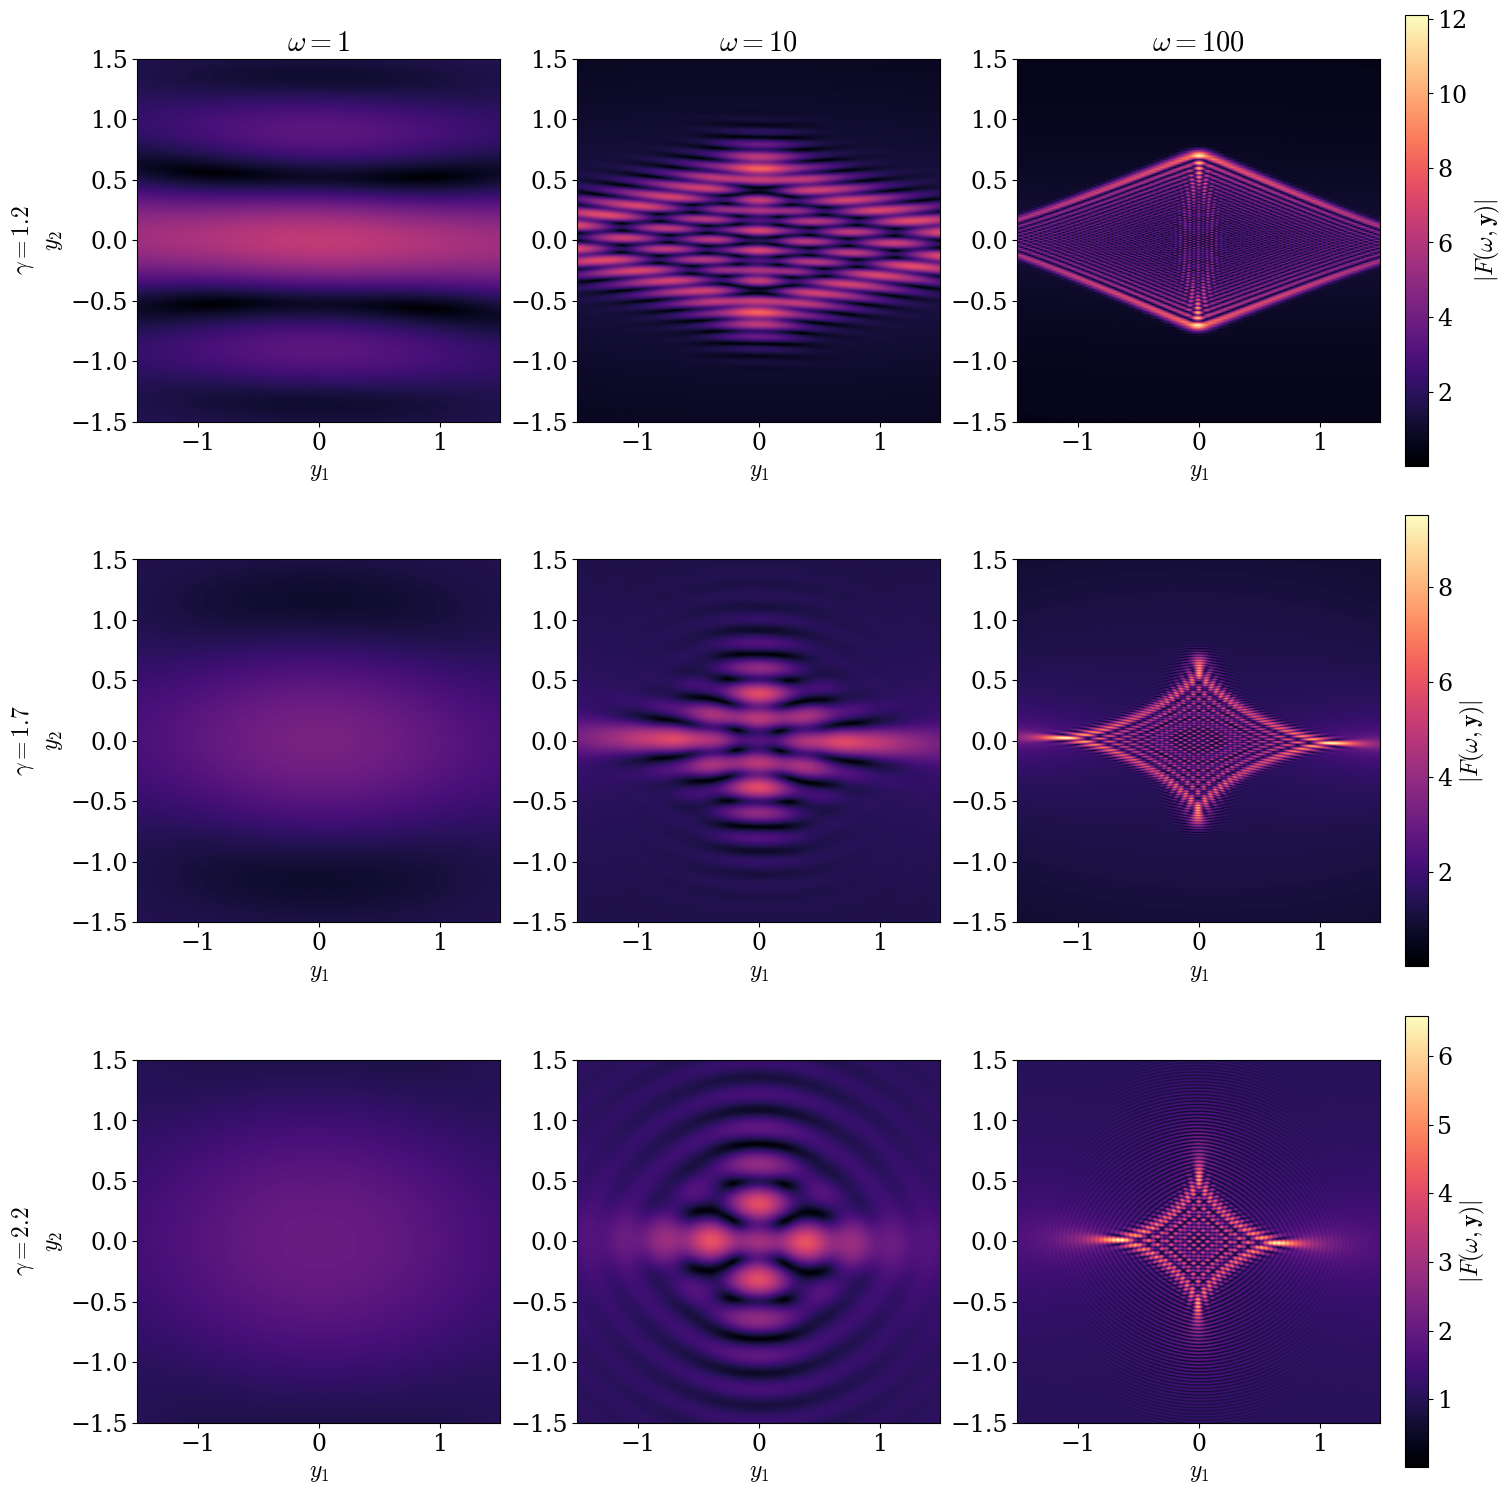

In [6]:
plot_EPL_shear_gamma_w_grid_row_colorbars_type3(
    gamma_list=(1.2, 1.7, 2.2),
    w_list=(1.0, 10.0, 100.0),
    e1=0.2,
    e2=0.0,
    theta_E=1.0,
    shear_g1=0.03,
    shear_g2=0.01,
    gl_nodes_per_dim=5000,
    min_physical_radius=10.0,
    nufft_tol=1e-9,
    numexpr_nthreads=1,
    y_extent=1.5,
    Ny=500,
    Nx=500,
    cmap="magma",
    font_size=17,
    verbose=False,
)


## 5. Elliptical NFW + External Shear

The **Navarro–Frenk–White** (NFW) profile is parameterised here by the halo
mass $M_{200}$ and concentration $c_{200}$.  Physical units are converted to
lenstronomy angular parameters $(R_s, \alpha_{R_s})$ via
`LensCosmo.nfw_physical2angle` from the *lenstronomy* package.

The three rows correspond to increasing concentration with the halo mass fixed;
the three columns span the same frequency range as the EPL section.


### 5.1 Additional imports

The NFW section requires *lenstronomy* and *astropy* for cosmological distance
calculations and the `NFW_ELLIPSE_POTENTIAL` lens model from FIONA.


In [7]:
from astropy.cosmology import FlatLambdaCDM
from lenstronomy.Cosmo.lens_cosmo import LensCosmo

from fiona import NFW_ELLIPSE_POTENTIAL


### 5.2 Physical-to-angular parameter conversion

Given $M_{200}$ [M$_\odot$] and $c_{200}$, the helper below converts to the
angular scale radius $R_s$ and projected deflection angle $\alpha_{R_s}$
(both in arcseconds) expected by `NFW_ELLIPSE_POTENTIAL`.


In [8]:
def nfw_Mc_to_lenstronomy_Rs_alphaRs(M200, c200, z_lens, z_source, cosmo=None):
    """Convert (M200, c200) to lenstronomy angular parameters (Rs, alpha_Rs).

    Parameters
    ----------
    M200 : float
        Halo mass within the radius enclosing 200 times the critical density [M_sun].
    c200 : float
        NFW concentration parameter.
    z_lens : float
        Lens redshift.
    z_source : float
        Source redshift.
    cosmo : astropy.cosmology instance, optional
        Cosmology to use.  Defaults to a flat LCDM with H0=70, Omega_m=0.3.

    Returns
    -------
    Rs_arcsec : float
        Angular scale radius [arcsec].
    alpha_Rs_arcsec : float
        Deflection angle at the scale radius [arcsec].
    """
    if cosmo is None:
        cosmo = FlatLambdaCDM(H0=70.0, Om0=0.3, Ob0=0.048)
    lens_cosmo = LensCosmo(z_lens=z_lens, z_source=z_source, cosmo=cosmo)
    Rs_arcsec, alpha_Rs_arcsec = lens_cosmo.nfw_physical2angle(M=M200, c=c200)
    return float(Rs_arcsec), float(alpha_Rs_arcsec)


### 5.3 NFW concentration grid helper

For each concentration in `c_list` the function builds an elliptical NFW + shear
lens, runs a single NUFFT batch for all requested frequencies, and displays the
row-normalised magnification maps.


In [9]:
def plot_NFW_concentration_w_grid_row_colorbars(
    M200=1e13,
    c_list=(10.0, 30.0, 60.0),
    w_list=(3.0, 9.0, 27.0),
    z_lens=0.5,
    z_source=1.5,
    e1=0.2,
    e2=0.0,
    shear_g1=0.03,
    shear_g2=0.01,
    gl_nodes_per_dim=5000,
    min_physical_radius=500.0,
    nufft_tol=1e-13,
    numexpr_nthreads=64,
    y_extent=1.5,
    Ny=500,
    Nx=500,
    cmap="magma",
    font_size=17,
    verbose=False,
):
    """Plot |F(omega, y)| for an elliptical NFW + external shear lens.

    The grid is laid out as ``len(c_list)`` rows x ``len(w_list)`` columns.
    Each row varies the NFW concentration while keeping ``M200``, the ellipticity,
    and the shear fixed.  A shared colour scale is used within each row and one
    colourbar is drawn per row.

    Parameters
    ----------
    M200 : float
        Halo mass [M_sun].
    c_list : sequence of float
        NFW concentration values (one per row).
    w_list : sequence of float
        Dimensionless frequencies omega (one per column).
    z_lens : float
        Lens redshift.
    z_source : float
        Source redshift.
    e1, e2 : float
        Complex ellipticity components of the NFW lens.
    shear_g1, shear_g2 : float
        External shear components.
    gl_nodes_per_dim : int
        Number of Gauss-Legendre nodes per dimension for the quadrature grid.
    min_physical_radius : float
        Inner cut-off radius for the GL grid [physical units].
    nufft_tol : float
        Requested NUFFT accuracy.
    numexpr_nthreads : int
        Number of numexpr threads used for potential evaluation.
    y_extent : float
        Half-width of the source-plane grid in dimensionless units.
    Ny, Nx : int
        Number of pixels along each axis.
    cmap : str
        Matplotlib colour map name.
    font_size : int
        Base font size for axis labels and titles.
    verbose : bool
        Pass through to FresnelNUFFT3 for diagnostic output.
    """
    plt.rcParams.update({
        "font.family": "serif",
        "mathtext.fontset": "cm",
        "font.size": font_size,
    })

    c_list = list(c_list)
    w_list = np.asarray(w_list, dtype=float)

    # Build the Cartesian source-plane grid (flattened for the Type-3 NUFFT)
    y1 = np.linspace(-y_extent, y_extent, Nx)
    y2 = np.linspace(-y_extent, y_extent, Ny)
    Y1, Y2 = np.meshgrid(y1, y2, indexing="xy")
    y1_targets = Y1.ravel()
    y2_targets = Y2.ravel()

    fig, axes = plt.subplots(
        len(c_list),
        len(w_list),
        figsize=(5 * len(w_list), 5 * len(c_list)),
        constrained_layout=True,
    )

    for i, c200 in enumerate(c_list):
        # Convert physical NFW parameters to lenstronomy angular parameters
        Rs_arcsec, alpha_Rs_arcsec = nfw_Mc_to_lenstronomy_Rs_alphaRs(
            M200, c200, z_lens, z_source
        )

        # Build the elliptical NFW lens
        nfw_lens = NFW_ELLIPSE_POTENTIAL(
            Rs=Rs_arcsec,
            alpha_Rs=alpha_Rs_arcsec,
            e1=e1,
            e2=e2,
            center_x=0.0,
            center_y=0.0,
        )

        # External shear
        shear = Shear(
            gamma1=shear_g1,
            gamma2=shear_g2,
            ra_0=0.0,
            dec_0=0.0,
        )

        lens = CompositeLens(nfw_lens, shear)

        # Initialise the NUFFT solver with log-spaced frequency binning
        nu3 = FresnelNUFFT3(
            lens,
            gl_nodes_per_dim=gl_nodes_per_dim,
            min_physical_radius=min_physical_radius,
            nufft_tol=nufft_tol,
            batch_frequencies=True,
            chunk_frequencies=True,
            frequency_binning="log",
            frequency_bin_width=0.5,
            auto_R_from_gl_nodes=True,
            use_tail_correction=True,
            coordinate_system="cartesian",
            numexpr_nthreads=numexpr_nthreads,
            verbose=verbose,
        )

        # Compute F for all frequencies in a single batch
        F = nu3(w_list, y1_targets, y2_targets, verbose=False)
        Fabs = np.abs(F)

        # Row-wise colour normalisation
        norm = Normalize(vmin=float(Fabs.min()), vmax=float(Fabs.max()))

        ims = []
        for j, w in enumerate(w_list):
            frame = Fabs[j].reshape(Ny, Nx)
            ax = axes[i, j]

            im = ax.imshow(
                frame,
                origin="lower",
                extent=[y1.min(), y1.max(), y2.min(), y2.max()],
                norm=norm,
                aspect="equal",
                cmap=cmap,
            )
            ims.append(im)

            if i == 0:
                ax.set_title(rf'$\omega={w:g}$')
            if j == 0:
                ax.set_ylabel(rf'$c_{{200}}={c200:g}$' + '\n' + r'$y_2$')
            else:
                ax.set_ylabel("")
            ax.set_xlabel(r'$y_1$')

            # Integer axis ticks for a clean appearance
            xticks = np.arange(np.ceil(-y_extent), np.floor(y_extent) + 1, 1)
            yticks = np.arange(np.ceil(-y_extent), np.floor(y_extent) + 1, 1)
            ax.set_xticks(xticks)
            ax.set_yticks(yticks)

        # One colourbar per row, anchored to all columns in that row
        cbar = fig.colorbar(
            ims[-1],
            ax=axes[i, :],
            shrink=0.95,
            pad=0.02,
        )
        cbar.set_label(r'$|F(\omega,\mathbf{y})|$')

    plt.show()


### 5.4 Generate the NFW maps

The amplification factor is computed for a $10^{13}\,M_\odot$ halo at
$z_{\rm lens}=0.5$, $z_{\rm source}=1.5$ with three concentrations
$c_{200} \in \{15,\, 30,\, 60\}$ and frequencies
$\omega \in \{1, 10, 100\}$.


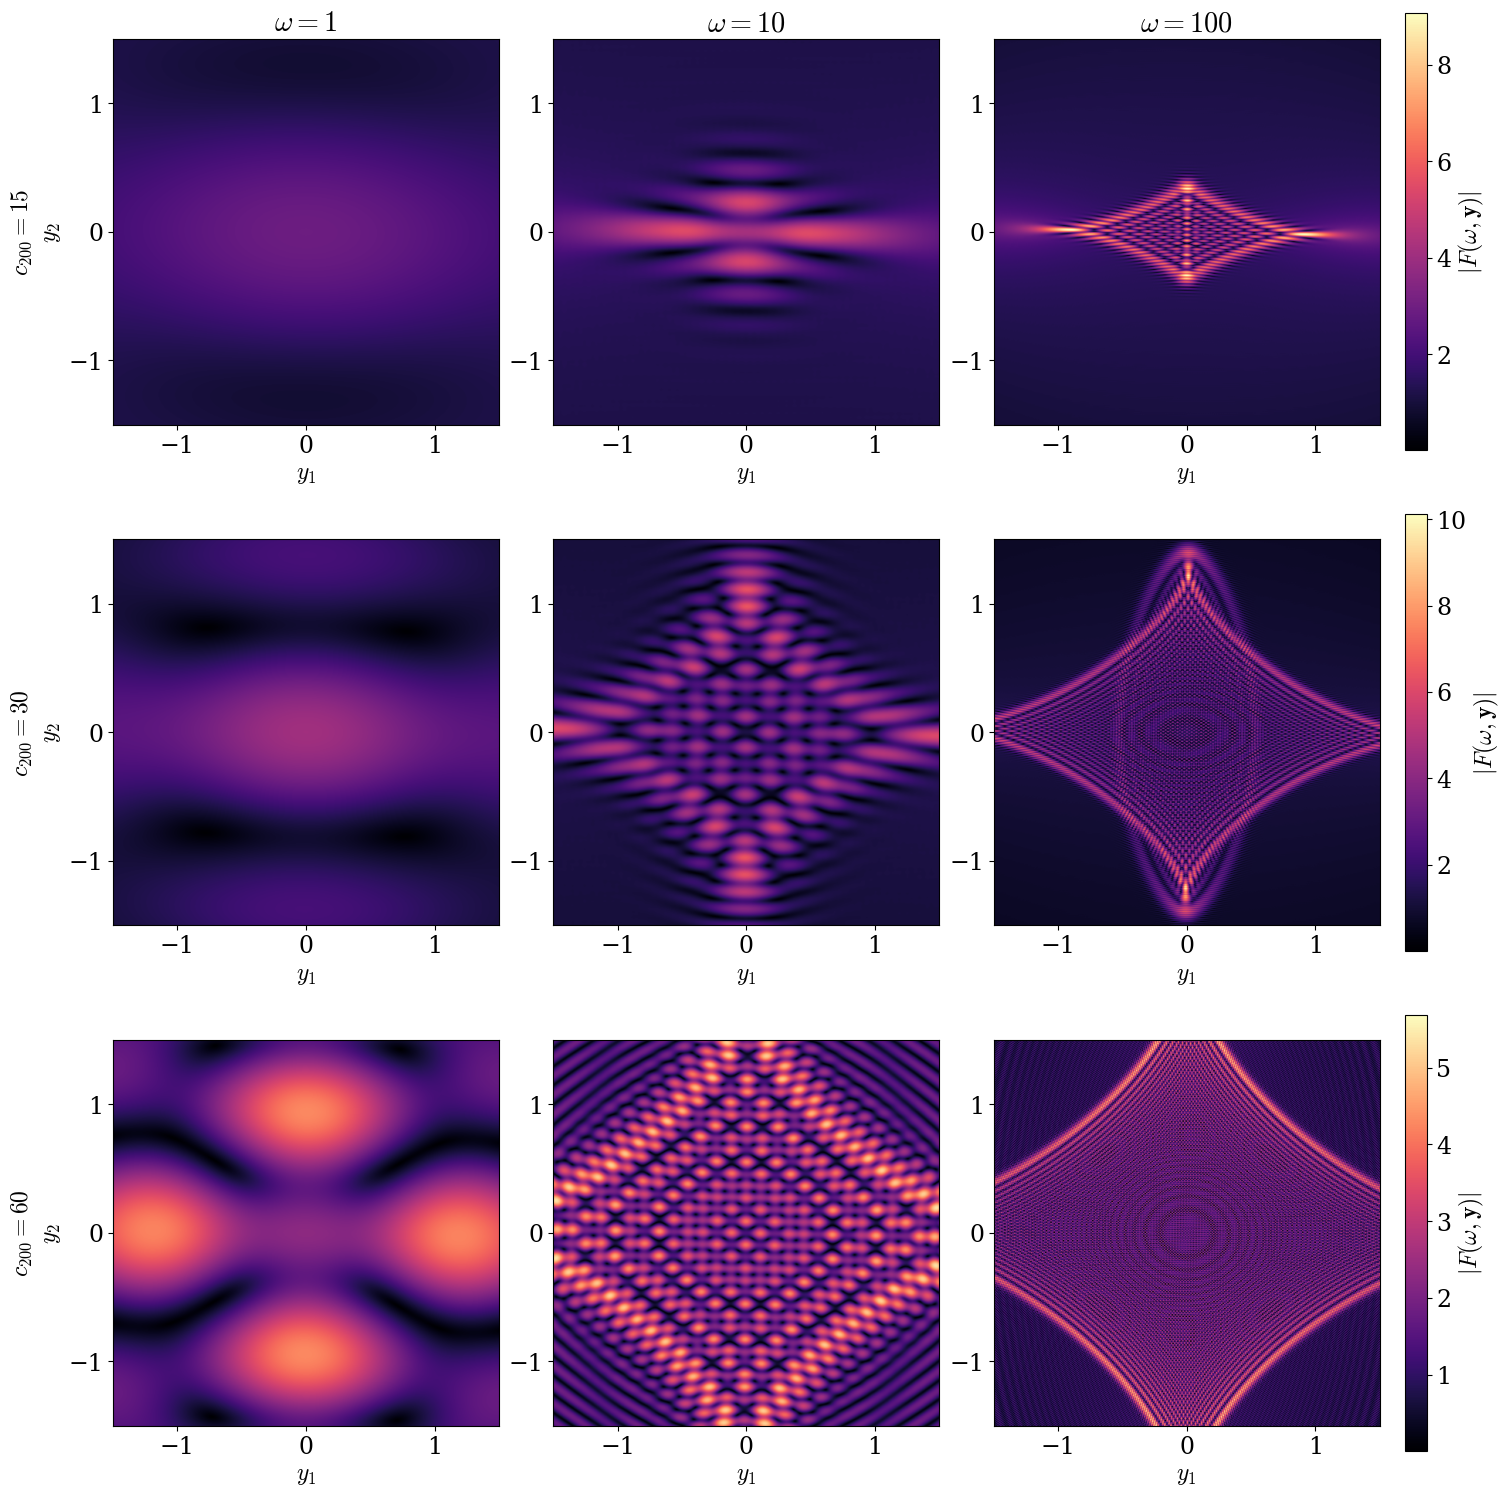

In [10]:
plot_NFW_concentration_w_grid_row_colorbars(
    M200=1e13,
    c_list=(15.0, 30.0, 60.0),
    w_list=(1.0, 10.0, 100.0),
    z_lens=0.5,
    z_source=1.5,
    e1=0.2,
    e2=0.0,
    shear_g1=0.03,
    shear_g2=0.01,
    gl_nodes_per_dim=5000,
    min_physical_radius=10.0,
    nufft_tol=1e-13,
    numexpr_nthreads=64,
    y_extent=1.5,
    Ny=500,
    Nx=500,
    cmap="magma",
    font_size=17,
    verbose=False,
)
